In [7]:
import pandas as pd

data = pd.read_csv('h1b_kaggle.csv')
data.shape

(3002458, 11)

In [8]:
data.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [4]:
data = data.head(70000)
data.to_csv(r'h1b_2.csv', index = False)

In [2]:
data = data.dropna()
data.shape

(2877765, 11)

In [ ]:
data['SOC_NAME'].value_counts()

In [32]:
data[['lon', 'lat']].describe()

,lon,lat
count,2.895216e+06,2.895216e+06
mean,-9.213441e+01,3.816054e+01
std,1.965591e+01,4.672835e+00
min,-1.578583e+02,1.343719e+01
25%,-1.119261e+02,3.416536e+01
50%,-8.615862e+01,3.910312e+01
75%,-7.551381e+01,4.088374e+01
max,1.457298e+02,6.483778e+01


### Clutersing the latitute and longitude to the location clusters

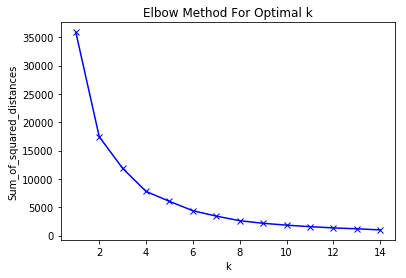

1320.359366


In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time


cluster_X = data[['lon', 'lat']]


mms = MinMaxScaler()
mms.fit(cluster_X)
l_tran = mms.transform(cluster_X)

Sum_of_squared_distances = []
K = range(1,15)

start = time.process_time()
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(l_tran)
    Sum_of_squared_distances.append(km.inertia_)
    

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

end = time.process_time()
duration = end - start
print(duration)

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time


cluster_X = data[['lon', 'lat']]
mms = MinMaxScaler()
mms.fit(cluster_X)
l_tran = mms.transform(cluster_X)
kmeans = KMeans(n_clusters=6, random_state=0).fit(l_tran)


In [4]:
data['loc_labels'] = kmeans.labels_
data['loc_labels'].count()

2877765

### One hot encoding

In [5]:
location = pd.get_dummies(data.loc_labels)

In [6]:
location.columns = ['loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5']
location.shape

(2877765, 6)

In [7]:
data = pd.concat([data, location], axis=1) 
data.columns.values

array(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME',
       'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE', 'lon', 'lat', 'loc_labels', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5'], dtype=object)

### Text Clustering by trying word2vec and cosine similarity.

In [3]:
#for i in data['SOC_NAME']:
    #i.strip()
data['SOC_NAME'] = data['SOC_NAME'].str.lower()    
data.SOC_NAME = data.SOC_NAME.str.strip()

In [4]:
import numpy as np

soc_uni = data.SOC_NAME.unique()
len(soc_uni)

1511

In [5]:
import nltk

token = [nltk.word_tokenize(i) for i in soc_uni]
token[:5]

[['biochemists', 'and', 'biophysicists'],
 ['chief', 'executives'],
 ['financial', 'managers'],
 ['general', 'and', 'operations', 'managers'],
 ['general', 'and', 'operations', 'manager']]

In [6]:
import re 
stopwords = ['and', 'd', 'other', '&' , '.', 'of', ',' , 'all', 'except', 'non', 'h', '<', '-', 'an','(',')',';',':','a','f']
for sen in token: 
    for i in sen:# iterating on a copy since removing will mess things up
        if i in stopwords:
            sen.remove(i)
token[:5]

[['biochemists', 'biophysicists'],
 ['chief', 'executives'],
 ['financial', 'managers'],
 ['general', 'operations', 'managers'],
 ['general', 'operations', 'manager']]

In [7]:
from gensim.models import Word2Vec
# define training data
# train model
model = Word2Vec(token, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
#print(words)
# access vector for one word
#print(model['CHIEF'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(type(new_model))

C:\Users\Young\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Word2Vec(vocab=1242, size=100, alpha=0.025)
<class 'gensim.models.word2vec.Word2Vec'>


In [9]:
import numpy as np

#Important Parameters
VOCAB_SIZE = len(model.wv.vocab)
EMBEDDING_DIM = model["biochemists"].shape[0]

w2v = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

C:\Users\Young\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [10]:

vec_file = open(r"d:\metadata_vec.tsv",'w+', encoding='utf-8')
name_file = open(r"d:\metadata_name.tsv",'w+', encoding='utf-8')

for i,word in enumerate(model.wv.index2word[:VOCAB_SIZE]):
    w2v[i] = model[word]
    arr = model[word]
    for val in arr:
        vec_file.write(f'{val}\t')
    vec_file.write('\n')
    name_file.write(f'{word}\n')
vec_file.close()
name_file.close()
    

C:\Users\Young\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Young\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


C:\Users\Young\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


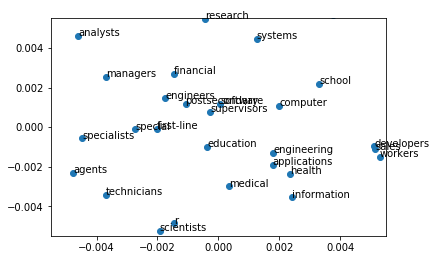

In [124]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# define training data
token
# train model
model = Word2Vec(token, min_count=25, size = 500)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.xlim(-0.0055, 0.0055)
plt.ylim(-0.0055, 0.0055)
pyplot.show()

### Generate Tfidf Matrix

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.corpus import stopwords

# set the min document frequency to 5
# generate tfidf matrix
tfidf_vect = TfidfVectorizer(stop_words="english")
                            #min_df = 0.2, max_df=0.5) 

dtm= tfidf_vect.fit_transform(soc_uni)
print (dtm.shape)

(2043, 1186)


In [11]:
from nltk.cluster import KMeansClusterer, \
cosine_distance

start_text_cluster = time.process_time()
# set number of clusters
num_clusters = 5

clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=20,
                           avoid_empty_clusters=True)

soc_cluster = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True
                               )

end_text_cluster = time.process_time()

duration_text = end_text_cluster - start_text_cluster

print('Running time: %s Seconds'%(duration_text))
print(soc_cluster[:5])


Running time: 15.65625 Seconds
[0, 0, 4, 4, 2]


In [12]:
keys = soc_uni
values = soc_cluster
dictionary = dict(zip(soc_uni, soc_cluster))

In [13]:
soc_label = []
for i in data['SOC_NAME']:
    soc_label.append(dictionary.get(i))

In [14]:
data['soc_label'] = soc_label
data.columns.values

array(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME',
       'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE', 'lon', 'lat', 'loc_labels', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5', 'soc_label'], dtype=object)

In [15]:
soc = pd.get_dummies(data.soc_label)

In [25]:
soc.shape

(2877765, 5)

In [22]:
len(soc_cluster)

2043

In [ ]:

data['soc_cluster'] = soc_cluster

data.columns.values

In [20]:
data.shape

(2877765, 19)

In [26]:
soc = pd.get_dummies(data.soc_label)

In [27]:
soc.columns = ['soc_0', 'soc_1', 'soc_2', 'soc_3', 'soc_4']
soc.shape

(2877765, 5)

In [28]:
data = pd.concat([data, soc], axis=1) 
data.columns.values

array(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME',
       'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE', 'lon', 'lat', 'loc_labels', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5', 'soc_label', 'soc_0', 'soc_1', 'soc_2',
       'soc_3', 'soc_4'], dtype=object)

In [29]:
data['YEAR'].unique()
year = pd.get_dummies(data.YEAR)

In [30]:
year.columns = ['2011','2012','2013','2014','2015','2016']
year.shape

(2877765, 6)

In [31]:
data = pd.concat([data, year], axis=1) 
data.columns.values

array(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME',
       'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE', 'lon', 'lat', 'loc_labels', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5', 'soc_label', 'soc_0', 'soc_1', 'soc_2',
       'soc_3', 'soc_4', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype=object)

In [32]:
data['FULL_TIME_POSITION'] = data['FULL_TIME_POSITION'].replace('N', 0)
data['FULL_TIME_POSITION'] = data['FULL_TIME_POSITION'].replace('Y', 1)
data['FULL_TIME_POSITION']
data.columns.values

array(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME',
       'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE', 'lon', 'lat', 'loc_labels', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5', 'soc_label', 'soc_0', 'soc_1', 'soc_2',
       'soc_3', 'soc_4', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype=object)

In [54]:
data['CASE_STATUS'].value_counts()

CERTIFIED                                             2512114
CERTIFIED-WITHDRAWN                                    195721
DENIED                                                  85161
WITHDRAWN                                               84752
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    1
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

### Define the classification goal:
    # set 'certified' and 'certified-withdrawn' as successful issued
    # set others as failed

In [33]:
data['CASE_STATUS'] = data['CASE_STATUS'].replace(['CERTIFIED', 'CERTIFIED-WITHDRAWN'], 1)
data['CASE_STATUS'] = data['CASE_STATUS'].replace(['DENIED', 'WITHDRAWN', 'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED', \
                                                                 'REJECTED', 'INVALIDATED'], 0)

In [34]:
data = data.drop(['Unnamed: 0', 'EMPLOYER_NAME', 'JOB_TITLE','WORKSITE','loc_labels','soc_label'], axis=1)

In [36]:
data = data.drop(['SOC_NAME', 'lon', 'lat'], axis = 1)

In [38]:
data = data.drop('YEAR', axis = 1)

In [41]:
from sklearn import preprocessing
data['wage_scaled'] = preprocessing.scale(data['PREVAILING_WAGE'])

In [42]:
data = data.drop('PREVAILING_WAGE', axis = 1)

In [43]:
data.columns.values

array(['CASE_STATUS', 'FULL_TIME_POSITION', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'loc_5', 'soc_0', 'soc_1', 'soc_2', 'soc_3',
       'soc_4', '2011', '2012', '2013', '2014', '2015', '2016',
       'wage_scaled'], dtype=object)

In [47]:
data.to_csv(r'h1b_2.csv')